1channel짜리 feature 뽑아보기

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import torchvision
from torchvision.transforms import transforms
import matplotlib.pyplot as plt 

# check if gpu training is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    
print("Using...", device)

Using... cuda


In [2]:
n_channel=1

In [16]:
# 1ch. 
if n_channel == 1:
    from atm.simclr import resnet
    fn_save = './runs/Resnet_ch1_stl10_bn128_399.pth'
    transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: x.mean(dim=0, keepdim=True)),
     transforms.Normalize((0.5), (0.5))])
elif n_channel == 3:
    from torchvision.models import resnet
    fn_save = './runs/resnet_ch3_399.pth'
    transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
model = resnet.resnet50(pretrained=False, num_classes=10)
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
checkpoint = torch.load(fn_save, map_location=device)
state_dict = checkpoint['state_dict']

log = model.load_state_dict(state_dict, strict=False)

print(log)

<All keys matched successfully>


In [5]:
model.fc

Linear(in_features=2048, out_features=10, bias=True)

In [6]:
# Remove the last FC
model.fc = nn.Identity()

##  Get the features 

In [7]:
batch_size = 64

#testset = torchvision.datasets.CIFAR10(root='./data', train=False,
test_set = torchvision.datasets.STL10(root='./data', split='test',
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


In [10]:
feature_arr = []
label_arr = []
for images, l in test_loader:
    images = images.to(device)

    #with autocast(enabled=args.fp16_precision):
    features = model(images)
        
    feature_arr.append(features.cpu().detach().numpy())
    label_arr.append(l)

feature_arr = np.concatenate(feature_arr)
label_arr = np.concatenate(label_arr)

print("feature vector dim must be 2048", features.shape)
print("feature min max", features.min(), features.max()) # 0 ~ 2.x? 

/home/hoseung/anaconda3/envs/tm39/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


feature vector dim must be 2048 torch.Size([64, 2048])
feature min max tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(4.8699, device='cuda:0', grad_fn=<MaxBackward1>)


# t-SNE

[t-SNE] Computing 226 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.005s...
[t-SNE] Computed neighbors for 8000 samples in 1.301s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 5.119069
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.333954
[t-SNE] KL divergence after 1000 iterations: 2.228135


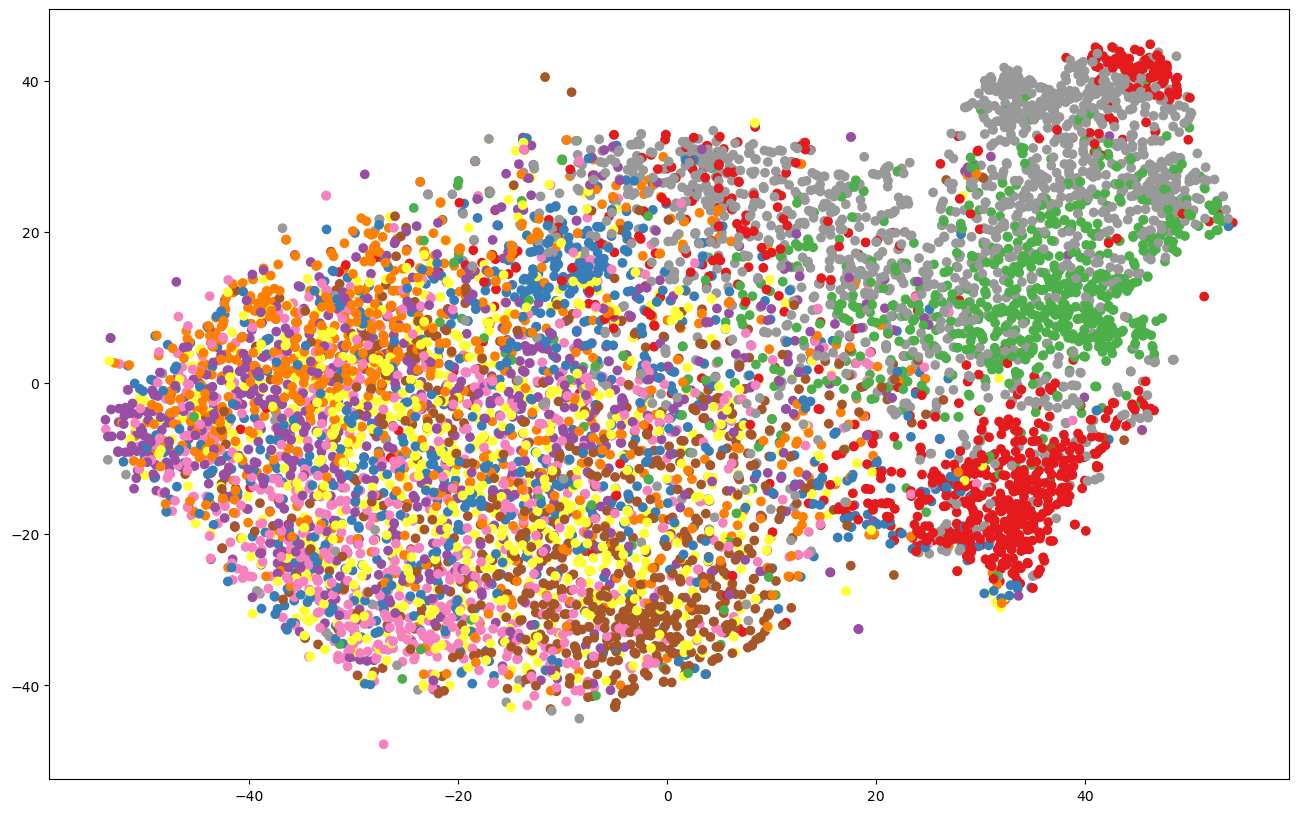

In [18]:
from sklearn.manifold import TSNE

perp = 75
n_iter = 1000
tsne = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=n_iter)
# n_components : the number of reduced dimension.
# perplexity : (roughly) number of neighbors.
tsne_results = tsne.fit_transform(feature_arr)

plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=label_arr, cmap='Set1')
plt.savefig(f"1ch_stl_400epochs_perp{perp}_iter{n_iter}.png")
plt.show()

오.... 쪼금 나옴! 

# Evaluate

Freeze all the layers.

In [20]:
# freeze all layers
for name, param in model.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False

parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
assert len(parameters) == 2  # fc.weight, fc.bias

print("un-freezed parameters:", len(parameters))

un-freezed parameters: 2


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0008)
criterion = torch.nn.CrossEntropyLoss().to(device)

In [21]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [22]:
top1_accuracy = 0
top5_accuracy = 0
for counter, (x_batch, y_batch) in enumerate(test_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(x_batch)

    top1, top5 = accuracy(logits, y_batch, topk=(1,5))
    top1_accuracy += top1[0]
    top5_accuracy += top5[0]
    
top1_accuracy /= (counter + 1)
top5_accuracy /= (counter + 1)
print(f"Top1 Test accuracy: {top1_accuracy.item()}\tTop5 test acc: {top5_accuracy.item()}")

Top1 Test accuracy: 45.55000305175781	Top5 test acc: 88.35000610351562


Trained model show a reasonable performance.

In [ ]:
epochs = 100
for epoch in range(epochs):
    top1_train_accuracy = 0
    for counter, (x_batch, y_batch) in enumerate(train_loader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        top1 = accuracy(logits, y_batch, topk=(1,))
        top1_train_accuracy += top1[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    top1_train_accuracy /= (counter + 1)
    top1_accuracy = 0
    top5_accuracy = 0
    for counter, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(x_batch)

        top1, top5 = accuracy(logits, y_batch, topk=(1,5))
        top1_accuracy += top1[0]
        top5_accuracy += top5[0]

    top1_accuracy /= (counter + 1)
    top5_accuracy /= (counter + 1)
    print(f"Epoch {epoch}\tTop1 Train accuracy {top1_train_accuracy.item()}\tTop1 Test accuracy: {top1_accuracy.item()}\tTop5 test acc: {top5_accuracy.item()}")